# CFRM 421 Final Proejct - Terence Chiu

# Introduction

What is the goal of your project?

• What is the data that you are using? What is the original data source if known?

• What does an instance in your data represent (e.g. a person, a transaction, etc.)? How many
instances are there?

• What is the target variable you are trying to predict?

• What are the features used to predict it? Give a few examples of the features.

• Provide any additional relevant information about your data if known (e.g. what is the time
period, what place is it collected from, etc.

# Problem Setup

In [33]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from terenceModel import DNN


# Algorithms

DNN  
Inputs:
- Weekly Import
- Weekly Production
- Weekly Supply
- Crude Oil Futures Price 1-2 minutes before release  

Outputs (predict): 
- Futures Price 1-2 minutes after release

Model Definition

Preparing the data

Define plot method to compare predicted and actual price at T+2 minutes after weekly report release

In [34]:
import pandas as pd
import numpy as np
df = pd.read_csv("full_data.csv")

feature_cols = [col for col in df.columns if 'Close_t-60'  in col or 'Close_t-40' in col or 'Close_t-20' in col or col == 'Release Date' or col == 'Actual' or col == 'Weekly Net Import' or col == 'Weekly Production' or col == 'Open_t0']

X_temp = df[feature_cols]
y_temp = (df['Close_t2'] - df['Close_t0'])/df['Close_t0']

In [35]:
prod_weekly = X_temp[['Release Date', 'Weekly Production']]
net_import_weekly = X_temp[['Release Date', 'Weekly Net Import']]
supply_weekly = X_temp[['Release Date', 'Actual']]
price_wide = X_temp[['Release Date', 'Close_t-60', 'Close_t-40', 'Close_t-20', 'Open_t0']]

In [36]:
from sklearn.preprocessing import StandardScaler

price_scaler = StandardScaler()
target_scaler = StandardScaler()

price_features = price_wide[['Close_t-60', 'Close_t-40', 'Close_t-20', 'Open_t0']]

# Scale the price features in the dataframe
for col in ['Close_t-60', 'Close_t-40', 'Close_t-20', 'Open_t0']:
    price_features[col] = price_scaler.fit_transform(price_wide[col].values.reshape(-1, 1)).flatten()

# Scale the target values in the dataframe
y_temp = target_scaler.fit_transform(y_temp.values.reshape(-1, 1)).flatten()

/var/folders/vl/xcbt_9650nz8tknq733z87640000gn/T/ipykernel_22193/1514931792.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_features[col] = price_scaler.fit_transform(price_wide[col].values.reshape(-1, 1)).flatten()
/var/folders/vl/xcbt_9650nz8tknq733z87640000gn/T/ipykernel_22193/1514931792.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_features[col] = price_scaler.fit_transform(price_wide[col].values.reshape(-1, 1)).flatten()
/var/folders/vl/xcbt_9650nz8tknq733z87640000gn/T/ipykernel

In [37]:
#Scaler for weekly data
weekly_scaler = StandardScaler()

weekly_production_scaled = weekly_scaler.fit_transform(prod_weekly['Weekly Production'].values.reshape(-1, 1)).flatten()
weekly_import_scaled = weekly_scaler.fit_transform(net_import_weekly['Weekly Net Import'].values.reshape(-1, 1)).flatten()
weekly_supply_scaled = weekly_scaler.fit_transform(supply_weekly['Actual'].values.reshape(-1, 1)).flatten()

In [38]:
X = []
y = []

for idx, row in price_features.iterrows():
    # Target: price of future 2 minutes after release (already scaled)
    target_price = y_temp[idx]

    
    production_value = weekly_production_scaled[idx]
    import_value = weekly_import_scaled[idx]
    supply_value = weekly_supply_scaled[idx]

    row_data = [price_features['Close_t-60'].values[idx],price_features['Close_t-40'].values[idx],price_features['Close_t-20'].values[idx],price_features['Open_t0'].values[idx],production_value,import_value,supply_value]
    X.append(row_data)
    y.append(target_price)

X = np.array(X)
y = np.array(y)

In [39]:
from terenceModel import DNN
from terenceTrainModel import plot_predictions


In [40]:
# Time-based 80/20 split
n = len(X)
split_idx = int(n * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
 

In [41]:
# Compute sample weights for training and test sets
epsilon = 1e-6
sample_weights_train = np.abs(y_train) + epsilon
sample_weights_test = np.abs(y_test) + epsilon

model = DNN()

# Train model with sample weights
trained_model, _ = model.train(X_train, y_train, sample_weight=sample_weights_train)

# Predict on test set
y_pred = trained_model.predict(X_test).flatten()

# Weighted RMSE for test set
weighted_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred, sample_weight=sample_weights_test))
print(f"Weighted Test RMSE: {weighted_test_rmse:.4f}")

Epoch 1/100


/Users/terencechiu/Documents/CFRM421PROJECT/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5149 - mae: 0.7406 - rmse: 0.9829 - val_loss: 2.7968 - val_mae: 0.8403 - val_rmse: 1.1219
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1739 - mae: 0.7767 - rmse: 1.0575 - val_loss: 2.7950 - val_mae: 0.8406 - val_rmse: 1.1224
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0139 - mae: 0.8024 - rmse: 1.0543 - val_loss: 2.7937 - val_mae: 0.8421 - val_rmse: 1.1239
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8057 - mae: 0.7267 - rmse: 1.0048 - val_loss: 2.7920 - val_mae: 0.8416 - val_rmse: 1.1238
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2012 - mae: 0.7567 - rmse: 1.0367 - val_loss: 2.7922 - val_mae: 0.8420 - val_rmse: 1.1244
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7954 - mae: 0.6964 - rmse: 0.9616 - val_loss: 2.7896 - val_mae: 0.8417 - val_rmse: 1.1244
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5455 - mae: 0.7440 - rmse: 1.0521 - val_loss:

Baseline (Zero Prediction) Weighted RMSE: 1.5964
Model outperforms baseline (predicting zero change).
Test RMSE: 1.1163


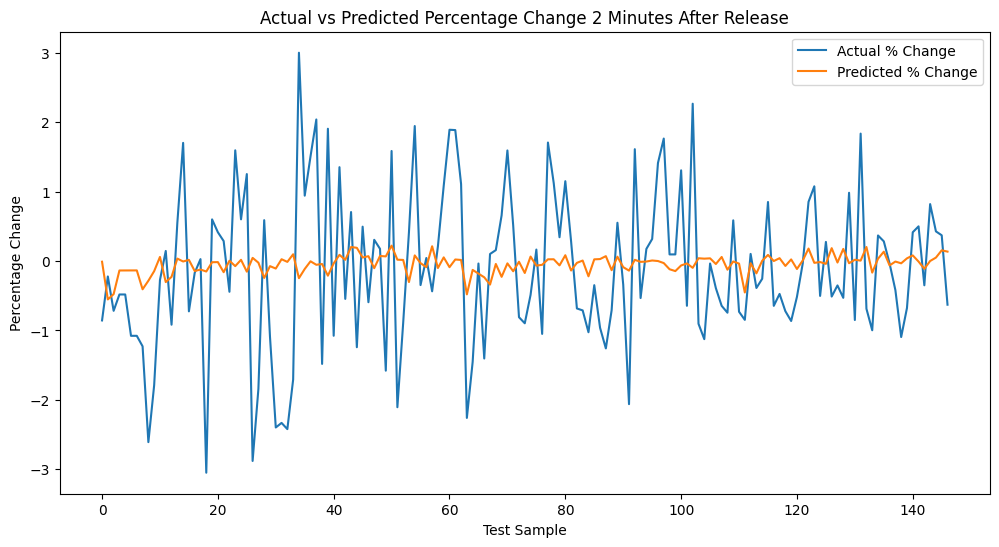

In [42]:
baseline_pred_zero = np.zeros_like(y_test)
baseline_rmse_zero = np.sqrt(mean_squared_error(y_test, baseline_pred_zero, sample_weight=sample_weights_test))
print(f"Baseline (Zero Prediction) Weighted RMSE: {baseline_rmse_zero:.4f}")

if weighted_test_rmse < baseline_rmse_zero:
    print("Model outperforms baseline (predicting zero change).")
else:
    print("Model does NOT outperform baseline (predicting zero change). Further investigation or model refinement needed.")

plot_predictions(y_pred, y_test)

# Conclusions